In [281]:
from automata.fa.dfa import DFA
from automata.fa.nfa import NFA 
from functools import reduce


In [282]:
state_id = -1

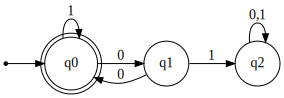

In [283]:
DFA(
    states={"q0", "q1", "q2"},
    input_symbols={"0", "1"},
    transitions={
        "q0": {"0": "q1", "1": "q0"},
        "q1": {"0": "q0", "1": "q2"},
        "q2": {"0": "q2", "1": "q2"},
    },
    initial_state="q0",
    final_states={"q0"},
).show_diagram()

In [284]:
A=DFA(
    states={"q0","q1","q2"},
    input_symbols={"0","1"},
    transitions={
        "q0":{"0":"q1","1":"q2"},
        "q1":{"0":"q0","1":"q2"},
        "q2":{"0":"q2","1":"q2"}
    },
    initial_state="q0",
    final_states={"q0"}
)

B=DFA(
    states={"q0","q1","q2"},
    input_symbols={"0","1"},
    transitions={
        "q0":{"1":"q1","0":"q2"},
        "q1":{"1":"q0","0":"q2"},
        "q2":{"1":"q2","0":"q2"}
    },
    initial_state="q0",
    final_states={"q0"}
)

In [285]:
def get_next_state_id() -> int:
    global state_id
    state_id += 1
    return state_id

def disambiguate_state_ids(s: DFA) -> DFA:
    mapping = {state: f"q{get_next_state_id()}" for state in s.states}

    new_transitions = dict()

    for state, transition in s.transitions.items():
        new_transitions[mapping.get(state)] = {input_symbol: mapping.get(next_state) for input_symbol, next_state in transition.items()}

    return DFA(
        states={mapping.get(state) for state in s.states},
        input_symbols=s.input_symbols,
        transitions=new_transitions,
        initial_state=mapping.get(s.initial_state),
        final_states={mapping.get(state) for state in s.final_states}
    )


In [286]:
def q2b(a: DFA, b: DFA) -> NFA:

    a, b = disambiguate_state_ids(a), disambiguate_state_ids(b)

    # for each state in a
    #   create an epsilon transition to the start state in b
    #   create an epsilon transition from the accept state in b to the start state of a copy of a

    # remove the accept state of a
    # remove the accept state of b

    # can assume only one accept state for b
    b_accept_state = set(b.final_states).pop()
    
    # connect any point in a to the initial state in b
    a_transitions = dict()
    for state, transition in a.transitions.items():
        new_transition = dict()
        for symbol, next_state in transition.items():
            new_transition[symbol] = set()
            new_transition[symbol].add(next_state)
        new_transition[""] = set()
        new_transition[""].add(b.initial_state)
        a_transitions[state] = new_transition
    
    # create a bunch of copies of a
    second_halves: list[DFA] = []
    a_copy_start_states = set()
    a_copy_final_states = set()

    for _i in b.states:
        a_copy = disambiguate_state_ids(a.copy())

        # record the initial and final states for connection
        a_copy_final_states.update(a_copy.final_states)
        a_copy_start_states.add(a_copy.initial_state)

        # track the copy
        second_halves.append(a_copy)

    # connect the accept state of b to the old initial state in all copies of a
    b_transitions = dict()
    for state, transition in b.transitions.items():
        new_transition = dict()
        for symbol, next_state in transition.items():
            new_transition[symbol] = set()
            new_transition[symbol].add(next_state)
        if state == b_accept_state:
            new_transition[""] = a_copy_start_states
        b_transitions[state] = new_transition
    
    a_copy_states = set()
    transitions = dict(a_transitions, **b_transitions)

    for dfa in second_halves:
        a_copy_states.update(set(dfa.states))
        
        a_copy_transitions = dict()
        for state, transition in dfa.transitions.items():
            new_transition = dict()
            for symbol, next_state in transition.items():
                new_transition[symbol] = set()
                new_transition[symbol].add(next_state)
            a_copy_transitions[state] = new_transition
        
        transitions.update(a_copy_transitions)
    
    # #states=
    # print(a.states | b.states | a_copy_states)
    # #input_symbols=
    # print(a.input_symbols | b.input_symbols)
    # #transitions=
    # print(transitions)
    # #initial_state=
    # print(a.initial_state)
    # #final_states=
    # print(a_copy_final_states)
    
    return NFA(
        states=a.states | b.states | a_copy_states,
        input_symbols=a.input_symbols | b.input_symbols,
        transitions=transitions,
        initial_state=a.initial_state,
        final_states=a_copy_final_states,
    )

SyntaxError: invalid syntax (1974813964.py, line 23)

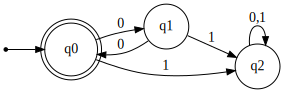

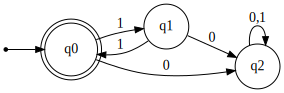

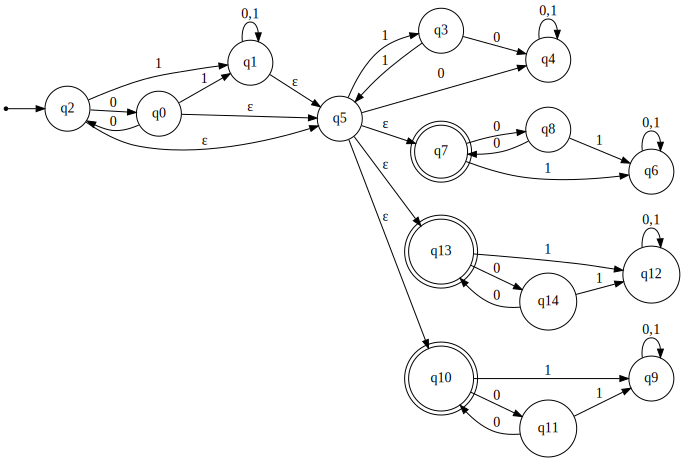

In [265]:
display(A)
display(B)
display(q2b(A, B))